In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time

from math import prod
import cv2

from ghost.multisim import GhostSimulator, GhostAnalyser

# plt.rcParams['text.usetex'] = True

Simulation using: SLM resolution (32, 32), camera resolution (8, 8)
Reconstructed Image


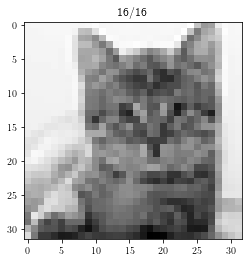

PSNR: inf
Original image:


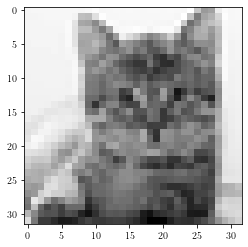

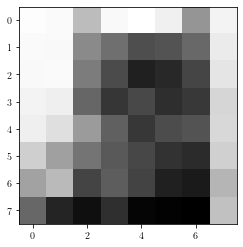

Active area of the camera


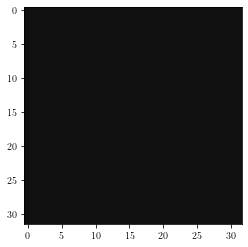

Cali matrix sum (should be uniform)


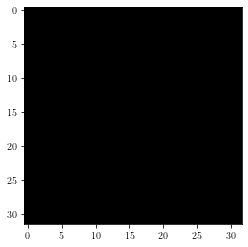

average: 1.0, min: 1.0, max: 1.0


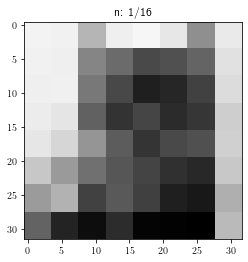

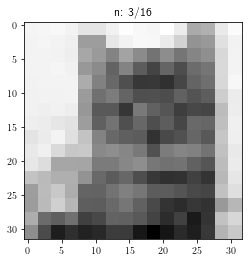

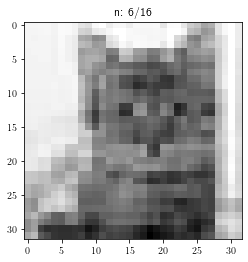

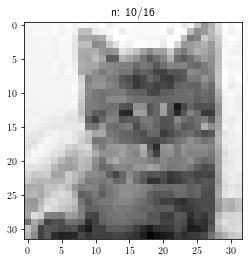

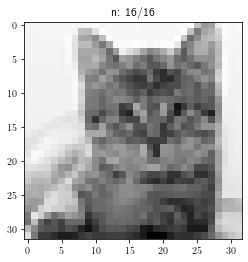

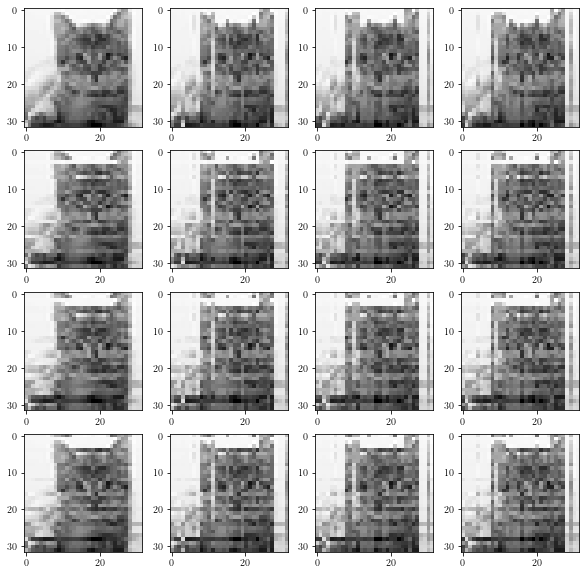

In [2]:
# path = '../common/RC_780.png'
# slm_res = (128, 128)
# camera_res = (32, 32)
# mac_res = (4, 4)
# n = 16

path = '../common/cat.png'
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
n = prod(mac_res)
sigma = 0


sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
cnt = sim.run_simulation()

print(f"Simulation using: SLM resolution {slm_res}, camera resolution {camera_res}")

print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()
# rmse = sim.calc_rmse()
# print('RMSE:', rmse)
psnr = sim.calc_psnr()
print('PSNR:', psnr)

print("Original image:")
plt.imshow(sim.T, vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

plt.imshow(cv2.resize(sim.T, camera_res, interpolation=cv2.INTER_AREA), cmap='gray')
plt.show()


# print(np.average(sim.T), np.average(sim.G2))

print("Active area of the camera")
plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), vmin=0, vmax=1, cmap='gray')
plt.show()

print("Cali matrix sum (should be uniform)")
plt.imshow(sim.A.sum(axis=1).reshape(sim.shape_slm), cmap='gray')
plt.show()
print(f"average: {np.average(sim.A.sum(axis=1))}, min: {np.min(sim.A.sum(axis=1))}, max: {np.max(sim.A.sum(axis=1))}")

for n in (1, 3, 6, 10, 16):
    sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
    cnt = sim.run_simulation()
    plt.title(f"n: {n}/{prod(mac_res)}")
    plt.imshow(np.abs(sim.G2), vmax=sim.T.flatten().max(), cmap='gray')
    plt.show()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

avg = np.zeros(mac_res)
for yr in range(4):
    for xr in range(4):
        shift = (yr, xr)
        sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, shift=shift, sigma=sigma, method='zigzag')
        cnt = sim.run_simulation()
        avg[yr, xr] = np.average(sim.G2.flatten())
        ax = axs[yr, xr]
        # ax.title(f"shift: {shift}, avg: {np.average(sim.G2.flatten())}")
        ax.imshow(np.abs(sim.G2), vmax=sim.T.flatten().max(), cmap='gray')
        # plt.savefig(f"../data/cat_shift/cat_shift({yr}, {xr})", bbox_inches='tight')

plt.show()

# _x = np.arange(4)
# _y = np.arange(4)
# _xx, _yy = np.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# top = avg.flatten()
# bottom = np.zeros_like(top)
# width = depth = 1

# fig = plt.figure(figsize=(8, 3))
# ax = fig.add_subplot(111, projection='3d')
# ax.bar3d(x, y, bottom, width, depth, top, shade=True)
# plt.show()

In [57]:
A = np.zeros((4, 4))
A[0, 0] = 1
A

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

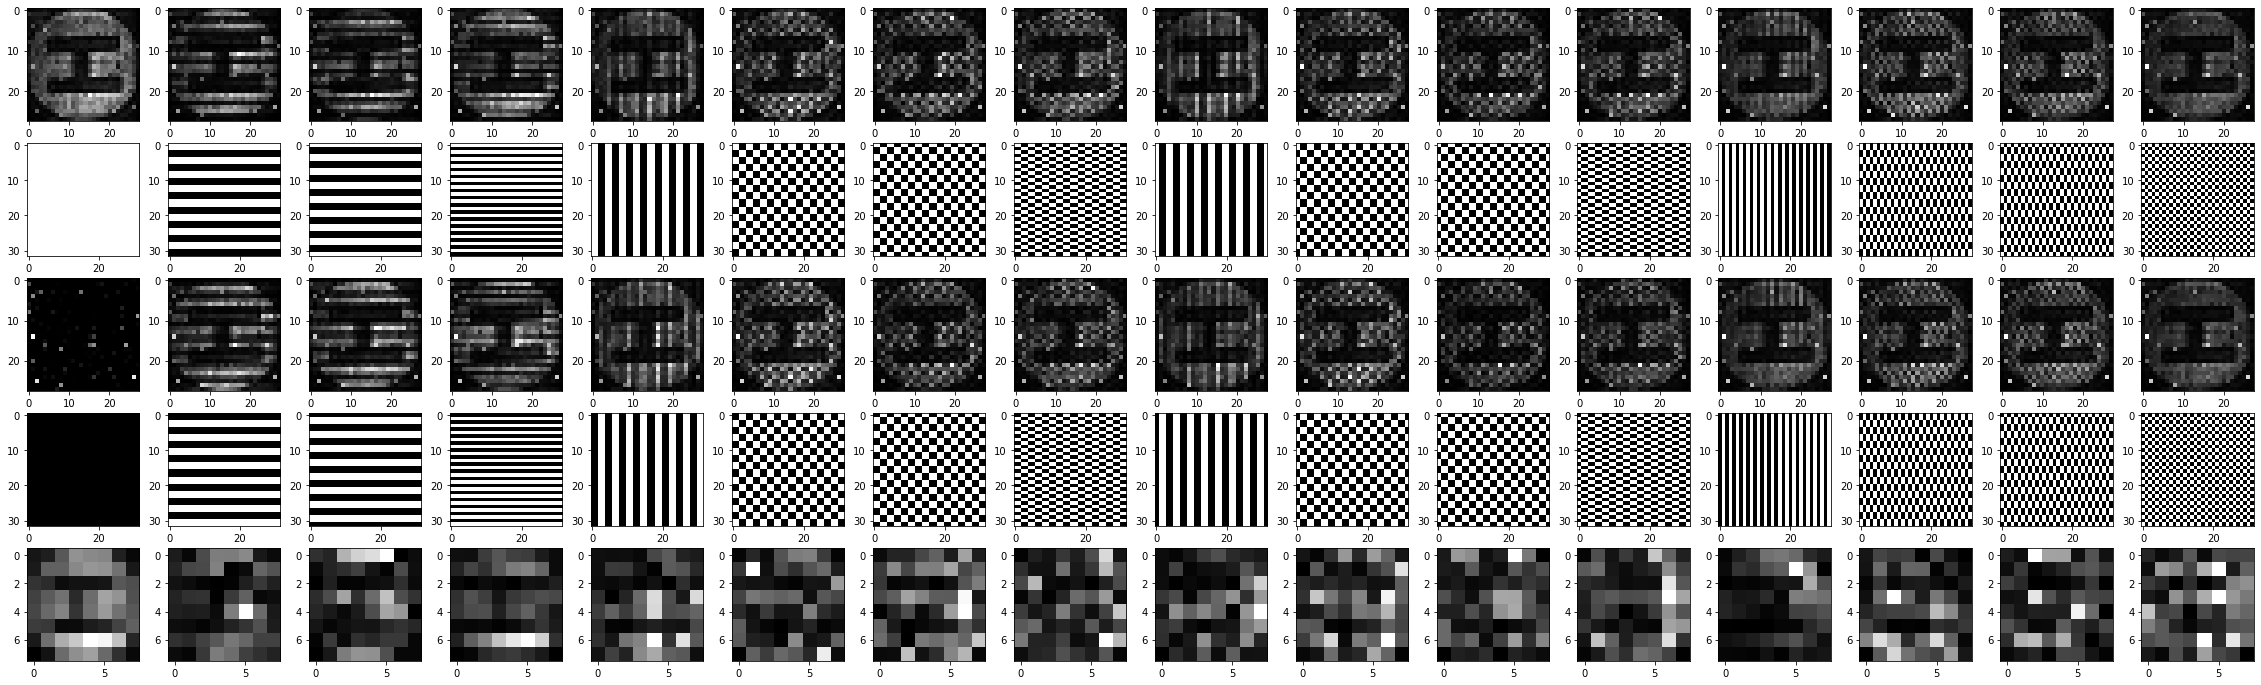

In [4]:
path = (r"D:\2022-2-16, Cat trial\\")
crop = (2, 2+28, 2, 2+28)

i = 0

sim = GhostAnalyser(path, (32, 32), (8, 8), (4, 4), crop, 16, spacing=(1, 1), sigma=0)

fig, axs = plt.subplots(5, 16, figsize=(40, 12))

for i in range(16):
    Ik_p = np.loadtxt(path + f'{i}p.csv', delimiter=',')
    Ik_m = np.loadtxt(path + f'{i}m.csv', delimiter=',')
    Ik_p = Ik_p[crop[0]:crop[1], crop[2]:crop[3]]
    Ik_m = Ik_m[crop[0]:crop[1], crop[2]:crop[3]]
    Ik = Ik_p - Ik_m
    Ik = cv2.resize(Ik, (8, 8), interpolation=cv2.INTER_AREA)

    axs[0, i].imshow(Ik_p, cmap='gray')    
    axs[1, i].imshow(sim.generate_filter2(i) == 1, vmin=0, vmax=1, cmap='gray')
    axs[2, i].imshow(Ik_m, cmap='gray')
    axs[3, i].imshow(sim.generate_filter2(i) == -1, vmin=0, vmax=1, cmap='gray')
    axs[4, i].imshow(np.abs(Ik), cmap='gray')

plt.show()

In [1]:
path = r"D:\2022-2-16, Cat trial\\HKSpacing3\\"
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
crop = (2, 2+28, 2, 2+28)
rot = (0, 0)
spacing = (3, 3)
n = 16
sigma = 1
mode = 'ideal'

# Ik_p = np.loadtxt(os.path.join(path, f'0p.csv'), delimiter=',')
# Ik_m = np.loadtxt(os.path.join(path, f'0m.csv'), delimiter=',')
# Ik = Ik_p - Ik_m
# plt.imshow(Ik, cmap='gray')
# plt.show()

# Ik = Ik[crop[0]:crop[1], crop[2]:crop[3]]
# plt.imshow(Ik, cmap='gray')
# plt.show()

# I_cropped = cv2.resize(Ik, (6, 6), interpolation=cv2.INTER_AREA)
# plt.imshow(I_cropped, cmap='gray')
# plt.show()


sim = GhostAnalyser(path, slm_res, camera_res, mac_res, crop, n, spacing=spacing, shift=rot, sigma=sigma, method='zigzag', mode=mode)
cnt = sim.run_analysis()

print(f"Simulation using: SLM resolution {slm_res}, camera resolution {camera_res}")
print("cnt", cnt)
print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), vmax=sim.G2.flatten().max(), cmap='gray')
plt.show()

sim.run_cali()

NameError: name 'GhostAnalyser' is not defined

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

avg = np.zeros(mac_res)
for yr in range(4):
    for xr in range(4):
        rot = (yr, xr)
        sim = GhostAnalyser(path, slm_res, camera_res, mac_res, crop, n, spacing=spacing, shift=(yr, xr), sigma=sigma, method='zigzag')
        cnt = sim.run_analysis()
        avg[yr, xr] = np.average(sim.G2.flatten())
        axs[yr, xr].imshow(np.abs(sim.G2), cmap='gray')

plt.show()

_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = avg.flatten()
bottom = np.zeros_like(top)
width = depth = 1

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x, y, bottom, width, depth, top, shade=True)
plt.show()


generate hadamard matrix


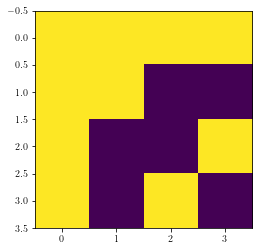

Generate some partial filter


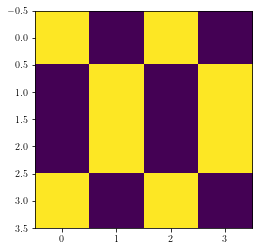

Generate some filter


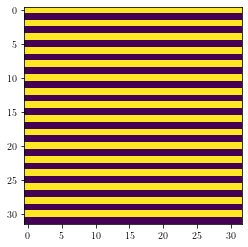

In [137]:
sim = GhostSimulator(path, slm_res, (24, 24), (4, 4),  64*64*0.1)

print("generate hadamard matrix")
h = sim.generate_hadamard()
plt.imshow(h)
plt.show()

print("Generate some partial filter")
hp = sim.generate_partial_filter(14)
plt.imshow(hp)
plt.show()

print("Generate some filter")
s = sim.generate_filter(3)
plt.imshow(s)
plt.show()

for i in range(16):
    s = sim.generate_filter(i)
    s_plus = s == 1
    s_minus = s == -1
    np.savetxt(f"../data/filter/filter_{i}+.txt", s_plus, fmt='%i')
    np.savetxt(f"../data/filter/filter_{i}-.txt", s_minus, fmt='%i')


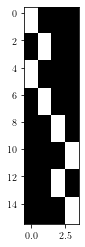

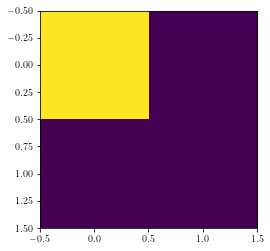

In [161]:
# ideal algo using cv2 resize

camera_res = (2, 2)
slm_res = (4, 4)

A = np.zeros((prod(slm_res), prod(camera_res)))

for i in range(slm_res[0]):
    for j in range(slm_res[1]):
        slm = np.zeros(slm_res)
        slm[i, j] = 1
        cam = cv2.resize(slm, camera_res, interpolation=cv2.INTER_AREA)
        cam = cam * prod(slm_res) / prod(camera_res)
        A[i*slm_res[1] + j, :] = cam.flatten()

plt.imshow(A, cmap='gray')
plt.show()

plt.imshow(A[5].reshape(camera_res))
plt.show()

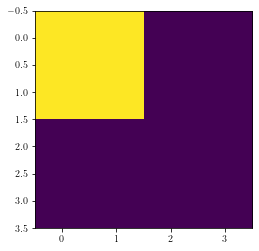

In [39]:
# simulate ideal algo

cam_res = (2, 2)
slm_res = (4, 4)

B = np.zeros(cam_res, dtype=np.ndarray)
for i in range(cam_res[0]):
    for j in range(cam_res[1]):
        B[i, j] = np.zeros(slm_res)
        for u in range(slm_res[0]):
            for v in range(slm_res[1]):
                if u >= i*slm_res[0]/cam_res[0] and u < (i+1)*slm_res[0]/cam_res[0] and v >= j*slm_res[1]/cam_res[1] and v < (j+1)*slm_res[1]/cam_res[1]:
                    B[i, j][u, v] = 1

plt.imshow(B[0,0])
plt.show()


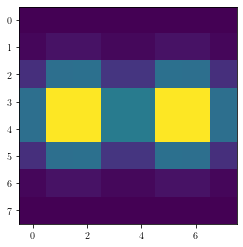

In [242]:
# optimizing gaussian simulation

cam_res = (2, 1)
slm_res = (8, 8)

sigma = 1

mac_res = slm_res[0]/cam_res[0], slm_res[1]/cam_res[1]

At = np.zeros((prod(cam_res), prod(slm_res)))
for i in range(prod(cam_res)):
        u, v = i // cam_res[1], i % cam_res[1]
        x = np.arange(0, slm_res[0], 1)
        y = np.arange(0, slm_res[1], 1)
        xv, yv = np.meshgrid(x, y)
        
        # simulate discrete gaussian
        xy = (xv - (u+0.5)*mac_res[0]+0.5)**2 + (yv - (v+0.5)*mac_res[1]+0.5)**2
        temp = 1/(2*np.pi*sigma**2)*np.exp(-xy/(2*sigma**2))

        At[i] = temp.flatten()

S = At.T.sum(axis=1, keepdims=True)
A = At.T/S

# plt.imshow(At[0].reshape(slm_res))
# plt.show()

plt.imshow(At.sum(axis=0).reshape(slm_res))
plt.show()

Simulation using: SLM resolution (32, 32), camera resolution (8, 8)
Original image:


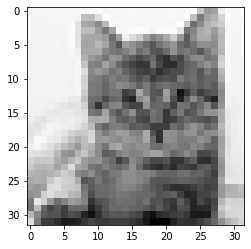

Reconstructed Image


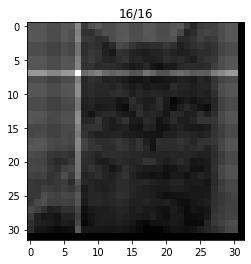

Active area of the camera


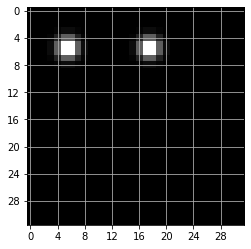

Last filter used


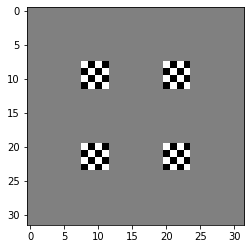

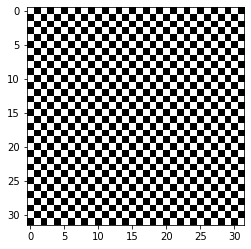

144


In [3]:
# image reconstruction simulation

# define simulation parameters
path = '../common/cat.png'
slm_res = (32, 32)
cam_res = (8, 8)
mac_res = (4, 4)
spacing = (3, 3)
shift = (1, 1)
n = 16
sigma = 1 # 0 for ideal calibration matrix
mode = 'gaussian'

# create simulation and run it
print(f"Simulation using: SLM resolution {slm_res}, camera resolution {cam_res}")
sim = GhostSimulator(path, slm_res, cam_res, mac_res, n, spacing=spacing, shift=shift, sigma=sigma, method='zigzag', mode='gaussian')
cnt = sim.run_simulation()

# show original image
print("Original image:")
plt.imshow(sim.T, vmax=sim.T.flatten().max(), cmap='gray')
plt.show()

# show reconstructed image
print("Reconstructed Image")
plt.title(f"{n}/{prod(mac_res)}")
plt.imshow(np.abs(sim.G2), cmap='gray')
plt.show()

# show active area of the camera
print("Active area of the camera")
# plt.imshow(sim.At.sum(axis=0).reshape(sim.shape_slm), cmap='gray')
# sim.A, sim.At = sim.generate_cali_matrix_ideal2()
plt.imshow((sim.At[9]+sim.At[12]).reshape(sim.shape_slm), cmap='gray')
plt.grid()
plt.xticks(np.arange(0, 32, 4))
plt.yticks(np.arange(0, 32, 4))
plt.show()



# # show hadamard matrix
# print("Hadamard matrix")
# plt.imshow(sim.h, vmin=-1, vmax=1, cmap='gray')
# plt.show()

# show the last filter used
print("Last filter used")
plt.imshow(sim.generate_filter2(9*15+8), cmap='gray')
plt.show()

plt.imshow(sim.generate_filter(15), cmap='gray')
plt.show()

print(cnt)

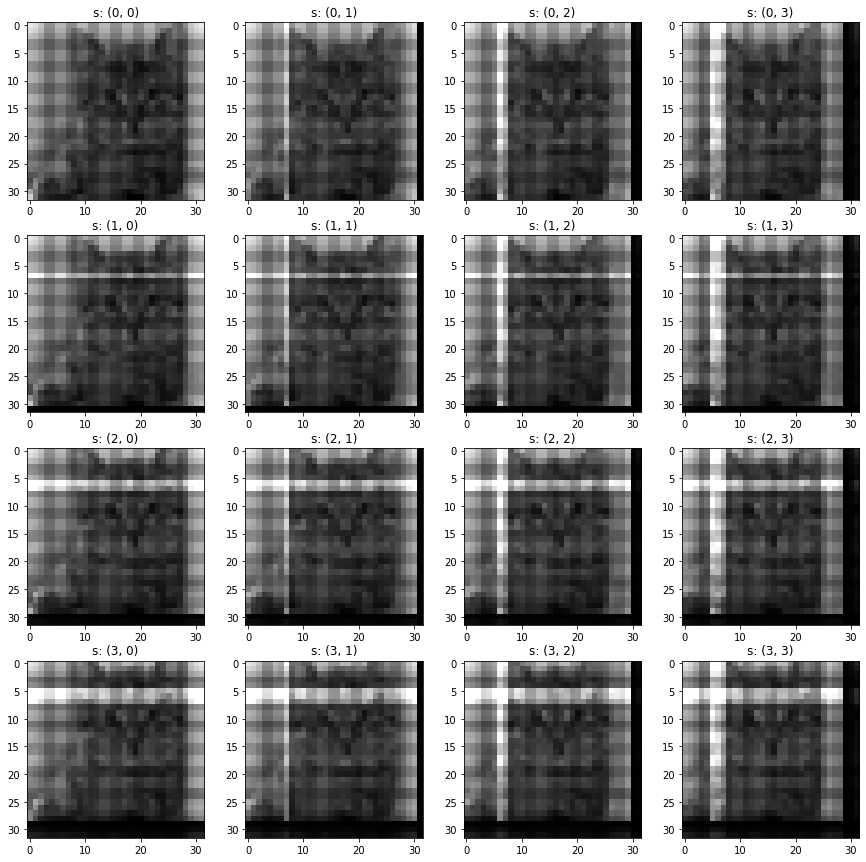

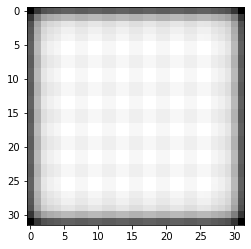

In [20]:
path = '../common/cat.png'
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
spacing = (3, 3)
n = 16
sigma = 2
mode = 'gaussian'

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

avg = np.zeros(mac_res)
for i in range(4):
    for j in range(4):
        shift = (i, j)
        sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, spacing=spacing, shift=shift, sigma=sigma, method='zigzag', mode=mode)
        cnt = sim.run_simulation()
        avg[i, j] = np.average(sim.G2.flatten())
        ax = axs[i, j]
        axs[i, j].set_title(f"s: {shift}")
        axs[i, j].imshow(np.abs(sim.G2), vmax=sim.T.flatten().max(),cmap='gray')

plt.show()

At = sim.At.sum(0).reshape(slm_res)
plt.imshow(At, cmap='gray')
plt.show()

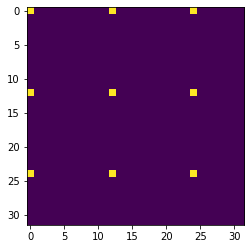

In [124]:
path = '../common/cat.png'
slm_res = (32, 32)
cam_res = (8, 8)
mac_res = (4, 4)
spacing = (3, 3)
shift = (1, 1)
n = 16
sigma = 1 # 0 for ideal calibration matrix
mode = 'gaussian'

sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, spacing=spacing, shift=shift, sigma=sigma, method='zigzag', mode=mode)

S = sim.generate_cali_pattern(0)
plt.imshow(S)
plt.show()

TypeError: unsupported operand type(s) for @: 'tuple' and 'int'

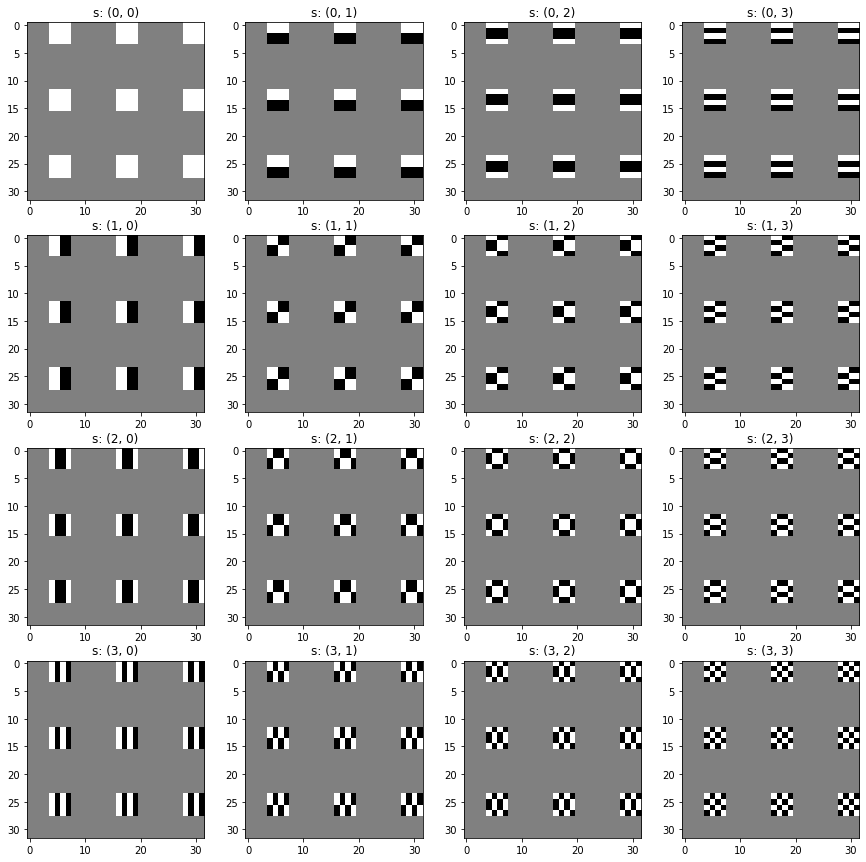

In [12]:
path = '../common/cat.png'
slm_res = (32, 32)
camera_res = (8, 8)
mac_res = (4, 4)
shift = (0, 0)
spacing = (3, 3)
n = 16
sigma = 1
mode = 'ideal'

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

avg = np.zeros(mac_res)
for i in range(4):
    for j in range(4):
        shift = (i, j)
        sim = GhostSimulator(path, slm_res, camera_res, mac_res, n, spacing=spacing, shift=shift, sigma=sigma, method='zigzag', mode=mode)
        # cnt = sim.run_simulation()
        axs[i, j].set_title(f"s: {shift}")
        axs[i, j].imshow(sim.generate_filter2(9*(i*4+j) + 1), vmin=-1, vmax=1, cmap='gray')
